In [10]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/TwitterSentimentProject')

print("✅ Setup complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup complete!


In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import pickle

print("✅ Libraries imported!")

✅ Libraries imported!


In [13]:
# Load data from Person 1
df = pd.read_csv('data/processed/tweets_preprocessed_person1.csv')

print(f"Dataset loaded: {len(df):,} rows")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head(3))

print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())

Dataset loaded: 99,357 rows
Columns: ['sentiment', 'text', 'text_cleaned', 'text_no_stopwords', 'text_lemmatized', 'cleaned_word_count', 'lemmatized_word_count']

First few rows:


,sentiment,text,text_cleaned,text_no_stopwords,text_lemmatized,cleaned_word_count,lemmatized_word_count
0,1,@stargazer60 that's awesome,thats awesome,thats awesome,thats awesome,2,2
1,1,@cunningstunts22 yes... i am!,yes i am,yes,yes,3,1
2,0,N my bed aaallll alone,n my bed aaallll alone,n bed aaallll alone,n bed aaallll alone,5,4



Sentiment distribution:
sentiment
1    49739
0    49618
Name: count, dtype: int64


In [15]:
df['text_lemmatized'].isna().sum()


np.int64(248)

In [16]:
# Remove NaN values
df = df.dropna(subset=['text_lemmatized'])

# Remove empty strings
df = df[df['text_lemmatized'].str.strip() != ""]

print(f"✅ Dataset size after cleaning: {len(df):,}")


✅ Dataset size after cleaning: 99,109


In [17]:
df = df.reset_index(drop=True)


In [20]:
# Create TF-IDF features
print("Creating TF-IDF features...")

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Keep top 5000 features
    min_df=5,           # Word must appear in at least 5 documents
    max_df=0.8,         # Word must appear in less than 80% of documents
    ngram_range=(1, 2)  # Unigrams and bigrams
)

# Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(df['text_lemmatized'])

print(f"✅ TF-IDF matrix created!")
print(f"Shape: {X_tfidf.shape}")
print(f"Features: {X_tfidf.shape[1]:,}")
print(f"Sparsity: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])) * 100:.2f}%")

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample features: {list(feature_names[:20])}")

Creating TF-IDF features...
✅ TF-IDF matrix created!
Shape: (99109, 5000)
Features: 5,000
Sparsity: 99.87%

Sample features: ['aa', 'aaah', 'aaron', 'abandon', 'able', 'able get', 'able go', 'able make', 'able see', 'absolutely', 'abt', 'abuse', 'ac', 'accent', 'accept', 'access', 'accident', 'accidentally', 'accomplish', 'accord']


In [22]:
# Get top TF-IDF features for each sentiment

def get_top_tfidf_features(tfidf_matrix, feature_names, sentiment_mask, top_n=20):
    """Get top TF-IDF features for a given sentiment"""
    # Sum TF-IDF scores for the sentiment
    tfidf_sum = np.array(tfidf_matrix[sentiment_mask.values].sum(axis=0)).flatten()
    # Get top indices
    top_indices = tfidf_sum.argsort()[-top_n:][::-1]
    # Get feature names and scores
    top_features = [(feature_names[i], tfidf_sum[i]) for i in top_indices]
    return top_features

# Get top features for each sentiment
positive_features = get_top_tfidf_features(X_tfidf, feature_names,
                                           df['sentiment'] == 1, top_n=20)
negative_features = get_top_tfidf_features(X_tfidf, feature_names,
                                           df['sentiment'] == 0, top_n=20)

print("="*70)
print("TOP 20 TF-IDF FEATURES - POSITIVE TWEETS")
print("="*70)
for i, (feature, score) in enumerate(positive_features, 1):
    print(f"{i:2d}. {feature:25s} (score: {score:.2f})")

print("\n" + "="*70)
print("TOP 20 TF-IDF FEATURES - NEGATIVE TWEETS")
print("="*70)
for i, (feature, score) in enumerate(negative_features, 1):
    print(f"{i:2d}. {feature:25s} (score: {score:.2f})")

TOP 20 TF-IDF FEATURES - POSITIVE TWEETS
 1. good                      (score: 943.16)
 2. love                      (score: 910.10)
 3. get                       (score: 888.95)
 4. im                        (score: 861.60)
 5. go                        (score: 823.05)
 6. thanks                    (score: 807.37)
 7. day                       (score: 712.87)
 8. like                      (score: 597.08)
 9. lol                       (score: 585.46)
10. time                      (score: 518.57)
11. well                      (score: 507.47)
12. see                       (score: 477.01)
13. make                      (score: 460.21)
14. thank                     (score: 457.15)
15. know                      (score: 453.75)
16. watch                     (score: 452.82)
17. today                     (score: 452.54)
18. great                     (score: 448.13)
19. new                       (score: 441.62)
20. not                       (score: 426.97)

TOP 20 TF-IDF FEATURES - NEGATIVE TWEE

In [23]:
# Create Count Vectorizer (alternative to TF-IDF)
print("Creating Count Vectorizer features...")

count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_count = count_vectorizer.fit_transform(df['text_lemmatized'])

print(f"✅ Count matrix created!")
print(f"Shape: {X_count.shape}")
print(f"Sparsity: {(1 - X_count.nnz / (X_count.shape[0] * X_count.shape[1])) * 100:.2f}%")

Creating Count Vectorizer features...
✅ Count matrix created!
Shape: (99109, 5000)
Sparsity: 99.87%


In [24]:
# Engineer additional features

# 1. Text length features
df['char_count'] = df['text_lemmatized'].apply(len)
df['word_count'] = df['lemmatized_word_count']

# 2. Average word length
df['avg_word_length'] = df['text_lemmatized'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)

# 3. Count of unique words
df['unique_word_count'] = df['text_lemmatized'].apply(
    lambda x: len(set(x.split()))
)

# 4. Lexical diversity (unique words / total words)
df['lexical_diversity'] = df['unique_word_count'] / (df['word_count'] + 1)

# 5. Exclamation and question marks (from original text)
df['exclamation_count'] = df['text'].apply(lambda x: str(x).count('!'))
df['question_count'] = df['text'].apply(lambda x: str(x).count('?'))

# 6. Capital letter ratio (from original text)
df['capital_ratio'] = df['text'].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1)
)

print("="*70)
print("ADDITIONAL FEATURES CREATED")
print("="*70)
print(f"1. Character count")
print(f"2. Word count")
print(f"3. Average word length")
print(f"4. Unique word count")
print(f"5. Lexical diversity")
print(f"6. Exclamation count")
print(f"7. Question count")
print(f"8. Capital letter ratio")

print("\nFeature statistics by sentiment:")
feature_cols = ['char_count', 'word_count', 'avg_word_length', 'unique_word_count',
                'lexical_diversity', 'exclamation_count', 'question_count', 'capital_ratio']

for col in feature_cols:
    print(f"\n{col}:")
    print(df.groupby('sentiment')[col].describe()[['mean', 'std']])

ADDITIONAL FEATURES CREATED
1. Character count
2. Word count
3. Average word length
4. Unique word count
5. Lexical diversity
6. Exclamation count
7. Question count
8. Capital letter ratio

Feature statistics by sentiment:

char_count:
                mean        std
sentiment                      
0          42.802189  23.398711
1          40.695485  23.218290

word_count:
               mean       std
sentiment                    
0          7.594221  4.000371
1          7.054692  3.892854

avg_word_length:
               mean       std
sentiment                    
0          4.802257  1.019307
1          4.981016  1.240112

unique_word_count:
               mean       std
sentiment                    
0          7.391604  3.819425
1          6.871216  3.726150

lexical_diversity:
               mean       std
sentiment                    
0          0.831426  0.090964
1          0.819748  0.099591

exclamation_count:
               mean       std
sentiment                    
0    

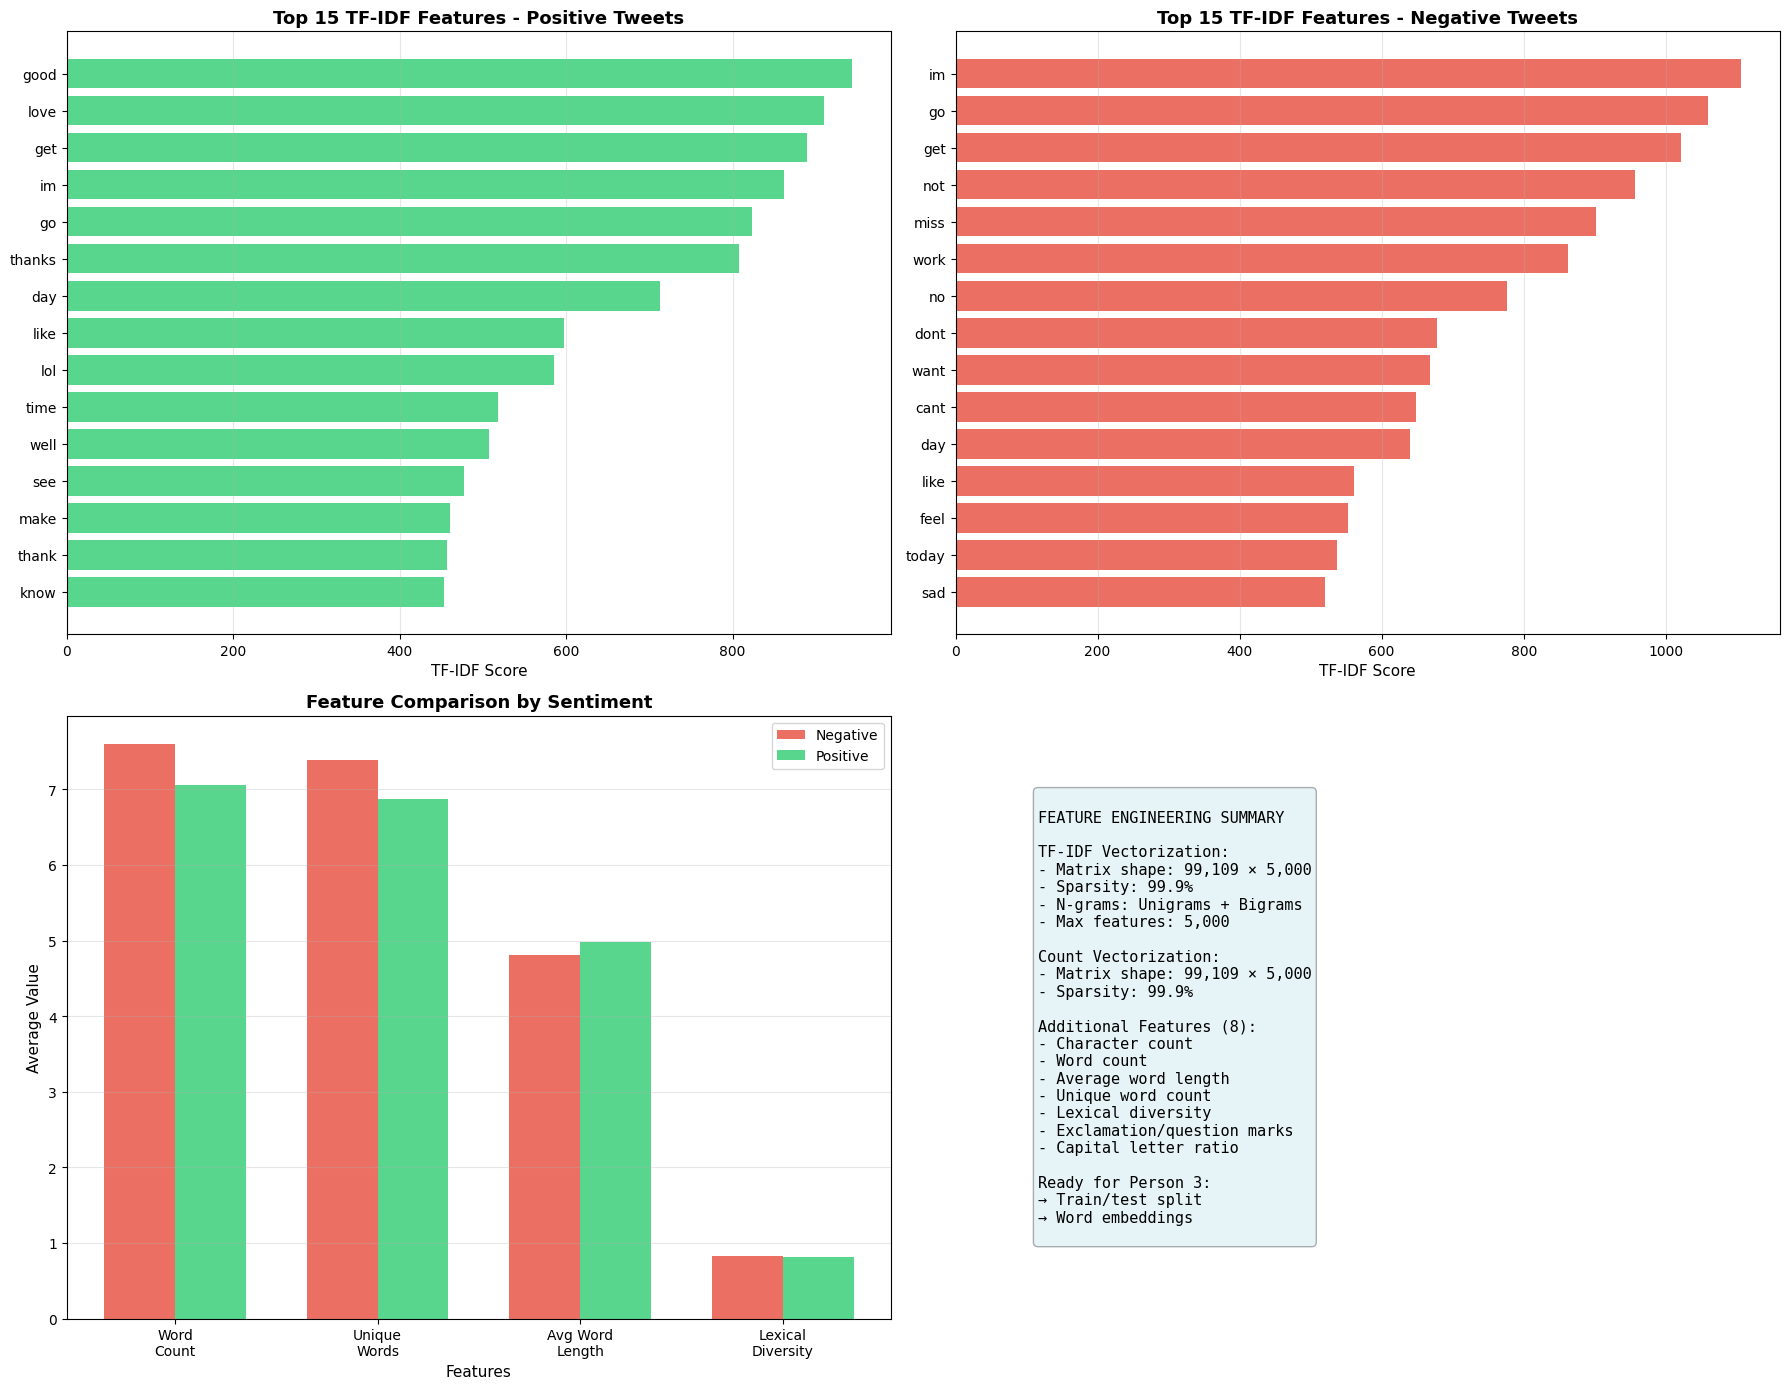

✅ Saved: results/figures/08_person2_feature_engineering.png


In [25]:
# Visualize TF-IDF top features
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Top TF-IDF features - Positive
pos_words, pos_scores = zip(*positive_features[:15])
axes[0, 0].barh(range(len(pos_words)), pos_scores, color='#2ecc71', alpha=0.8)
axes[0, 0].set_yticks(range(len(pos_words)))
axes[0, 0].set_yticklabels(pos_words, fontsize=10)
axes[0, 0].set_xlabel('TF-IDF Score', fontsize=11)
axes[0, 0].set_title('Top 15 TF-IDF Features - Positive Tweets',
                     fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Top TF-IDF features - Negative
neg_words, neg_scores = zip(*negative_features[:15])
axes[0, 1].barh(range(len(neg_words)), neg_scores, color='#e74c3c', alpha=0.8)
axes[0, 1].set_yticks(range(len(neg_words)))
axes[0, 1].set_yticklabels(neg_words, fontsize=10)
axes[0, 1].set_xlabel('TF-IDF Score', fontsize=11)
axes[0, 1].set_title('Top 15 TF-IDF Features - Negative Tweets',
                     fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Feature comparison
feature_comparison = df.groupby('sentiment')[['word_count', 'unique_word_count',
                                               'avg_word_length', 'lexical_diversity']].mean()

x = np.arange(len(feature_comparison.columns))
width = 0.35

axes[1, 0].bar(x - width/2, feature_comparison.loc[0], width,
               label='Negative', color='#e74c3c', alpha=0.8)
axes[1, 0].bar(x + width/2, feature_comparison.loc[1], width,
               label='Positive', color='#2ecc71', alpha=0.8)
axes[1, 0].set_xlabel('Features', fontsize=11)
axes[1, 0].set_ylabel('Average Value', fontsize=11)
axes[1, 0].set_title('Feature Comparison by Sentiment', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Word\nCount', 'Unique\nWords',
                            'Avg Word\nLength', 'Lexical\nDiversity'], fontsize=10)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Feature summary
axes[1, 1].axis('off')
summary_text = f"""
FEATURE ENGINEERING SUMMARY

TF-IDF Vectorization:
- Matrix shape: {X_tfidf.shape[0]:,} × {X_tfidf.shape[1]:,}
- Sparsity: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])) * 100:.1f}%
- N-grams: Unigrams + Bigrams
- Max features: 5,000

Count Vectorization:
- Matrix shape: {X_count.shape[0]:,} × {X_count.shape[1]:,}
- Sparsity: {(1 - X_count.nnz / (X_count.shape[0] * X_count.shape[1])) * 100:.1f}%

Additional Features (8):
- Character count
- Word count
- Average word length
- Unique word count
- Lexical diversity
- Exclamation/question marks
- Capital letter ratio

Ready for Person 3:
→ Train/test split
→ Word embeddings
"""

axes[1, 1].text(0.1, 0.5, summary_text,
                fontsize=11, family='monospace',
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig('results/figures/08_person2_feature_engineering.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: results/figures/08_person2_feature_engineering.png")

In [26]:
# Save TF-IDF matrix
from scipy.sparse import save_npz

# Create models folder if doesn't exist
!mkdir -p models

# Save TF-IDF matrix
save_npz('data/processed/X_tfidf.npz', X_tfidf)
print("✅ TF-IDF matrix saved")

# Save Count matrix
save_npz('data/processed/X_count.npz', X_count)
print("✅ Count matrix saved")

# Save vectorizers
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✅ TF-IDF vectorizer saved")

with open('models/count_vectorizer.pkl', 'wb') as f:
    pickle.dump(count_vectorizer, f)
print("✅ Count vectorizer saved")

# Save DataFrame with additional features
df.to_csv('data/processed/tweets_with_features_person2.csv', index=False)
print("✅ DataFrame with features saved")

print("\n" + "="*70)
print("✅ PERSON 2 TASK COMPLETE!")
print("="*70)
print("Deliverables:")
print("  • TF-IDF vectorization (5000 features)")
print("  • Count vectorization (5000 features)")
print("  • 8 additional engineered features")
print("  • Saved matrices and vectorizers")
print("  • Created visualization")

✅ TF-IDF matrix saved
✅ Count matrix saved
✅ TF-IDF vectorizer saved
✅ Count vectorizer saved
✅ DataFrame with features saved

✅ PERSON 2 TASK COMPLETE!
Deliverables:
  • TF-IDF vectorization (5000 features)
  • Count vectorization (5000 features)
  • 8 additional engineered features
  • Saved matrices and vectorizers
  • Created visualization


In [28]:
!git config --global user.name "zeynkash"  # Replace with your name
!git config --global user.email "030721077@std.izu.edu.tr"

In [30]:
%cd /content

/content


In [32]:
!git clone https://github.com/zeynkash/twitter-sentiment-analysis.git

Cloning into 'twitter-sentiment-analysis'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 0), reused 20 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 3.61 MiB | 11.59 MiB/s, done.


In [ ]:
%cd /content/twitter-sentiment-analysis


In [ ]:
!cp /content/drive/MyDrive/TwitterSentimentProject/notebooks/03_Phase2_Person2_FeatureEngineering.ipynb notebooks/
!cp /content/drive/MyDrive/TwitterSentimentProject/results/figures/08_person2_feature_engineering.png results/figures/

In [ ]:
!git add notebooks/03_Phase2_Person2_FeatureEngineering.ipynb
!git add results/figures/08_person2_feature_engineering.png

In [ ]:

!git commit -m "Phase 2 - Person 2: Feature Engineering"